In [1]:
import os
from scipy.misc import imread
from scipy.ndimage import gaussian_filter, zoom
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with np.load('faces.npz') as data:
    faces = data['images']
    blur_faces = gaussian_filter(faces, (0, 3, 3, 0))

In [3]:
mean = np.mean(faces)
std = np.std(faces)

In [4]:
mean, std

(0.58963877, 0.32052067)

In [5]:
import math
import tensorflow as tf

In [15]:
tf.reset_default_graph()
_x = tf.placeholder(tf.float32, [None, None, None, 3], name="input")
_y = tf.placeholder(tf.float32, [None, None, None, 3], name="label")

def relu(x):
    return (tf.nn.relu(x) - 0.3989422804014327) * 1.712858550449663

def convolution(x, f_out=None, s=1, w=3,
                input_repr='regular', output_repr='regular', padding='SAME',
                activation=relu, name='conv'):
    """The input and output tensor must tranform with the
     defining x (invariant / regular) representation
    where the x represent the tensor product between
    the spacial componant and the channels componant."""
    assert input_repr == 'regular' or input_repr == 'invariant'
    assert output_repr == 'regular' or output_repr == 'invariant'

    f_in = x.get_shape().as_list()[3]

    # pylint: disable=C0111
    def filters(d_in, d_out, n_mul=None):
        F0 = tf.random_normal([w, w, d_in, d_out])
        if n_mul is None:
            n_mul = w * w * d_in
        F0 = F0 / math.sqrt(n_mul)

        F = tf.Variable(F0, name="F")
        tf.summary.histogram("filter", F)

        if w > 1:
            Fs = [None] * 8
            Fs[0] = F  # tau[0]
            Fs[1] = tf.reverse(F, [1])  # tau[1]
            Fs[2] = tf.reverse(F, [0])  # tau[2]
            Fs[3] = tf.reverse(F, [0, 1])  # tau[3]
            Fs[4] = tf.transpose(F, [1, 0, 2, 3])  # tau[4]
            Fs[5] = tf.reverse(Fs[4], [1])  # tau[5]
            Fs[6] = tf.reverse(Fs[4], [0])  # tau[6]
            Fs[7] = tf.reverse(Fs[4], [0, 1])  # tau[7]
            # Fs[j] = tau[j] F
        else:
            Fs = [F] * 8

        return Fs

    if input_repr == 'regular' and output_repr == 'regular':
        if f_out is None:
            f_out = f_in
        assert f_in % 8 == 0 and f_out % 8 == 0

        with tf.name_scope("{}-8x{}-8x{}".format(name, f_in // 8, f_out // 8)):
            Fs = [tf.split(F, 8, 2) for F in filters(f_in, f_out // 8)]
            # Fs[j][i] = tau[j] F_i

            mt = np.array([
                [0, 1, 2, 3, 4, 5, 6, 7], [1, 0, 3, 2, 5, 4, 7, 6],
                [2, 3, 0, 1, 6, 7, 4, 5], [3, 2, 1, 0, 7, 6, 5, 4],
                [4, 6, 5, 7, 0, 2, 1, 3], [5, 7, 4, 6, 1, 3, 0, 2],
                [6, 4, 7, 5, 2, 0, 3, 1], [7, 5, 6, 4, 3, 1, 2, 0]])
            # tau[mt[a,b]] = tau[a] o tau[b]

            iv = np.array([0, 1, 2, 3, 4, 6, 5, 7])
            # tau[iv[a]] is the inverse of tau[a]

            F = tf.concat([  # merge 8 part of the output
                tf.concat([  # merge 8 part of the input
                    Fs[j][mt[iv[j], i]]
                    for i in range(8)], 2)
                for j in range(8)], 3)

            # y = Conv(x, W)
            x = tf.nn.conv2d(x, F, [1, s, s, 1], padding)

            b = tf.Variable(tf.constant(0.0, shape=[f_out // 8]), name="b")
            tf.summary.histogram("bias", b)
            x = x + tf.tile(b, [8])

            if activation is not None:
                x = activation(x)
            return x

    if input_repr == 'invariant' and output_repr == 'regular':
        if f_out is None:
            f_out = 8 * f_in
        assert f_out % 8 == 0

        with tf.name_scope("{}-{}-8x{}".format(name, f_in, f_out // 8)):
            F = tf.concat(filters(f_in, f_out // 8), 3)
            x = tf.nn.conv2d(x, F, [1, s, s, 1], padding)

            b = tf.Variable(tf.constant(0.0, shape=[f_out // 8]), name="b")
            tf.summary.histogram("bias", b)
            x = x + tf.tile(b, [8])

            if activation is not None:
                x = activation(x)
            return x

    if input_repr == 'regular' and output_repr == 'invariant':
        if f_out is None:
            f_out = f_in // 8
        assert f_in % 8 == 0

        with tf.name_scope("{}-8x{}-{}".format(name, f_in // 8, f_out)):
            F = tf.concat(filters(f_in // 8, f_out, n_mul=w * w * f_in), 2)
            x = tf.nn.conv2d(x, F, [1, s, s, 1], padding)

            b = tf.Variable(tf.constant(0.0, shape=[f_out]), name="b")
            tf.summary.histogram("bias", b)
            x = x + b

            if activation is not None:
                x = activation(x)
            return x

def NN(x):
    x = convolution(x, 8*4, input_repr='invariant')
    x = convolution(x, 8*6)
    x = convolution(x, 8*6)
    x = convolution(x, 8*6)
    x = convolution(x, 8*4)
    x = convolution(x, 3, output_repr='invariant', activation=None)
    return x

_r = _x + NN(_x)
_c = tf.reduce_mean(tf.square(_r - _y))
_t = tf.train.AdamOptimizer(1e-3).minimize(_c)

In [12]:
tf.reset_default_graph()
_x = tf.placeholder(tf.float32, [None, None, None, 3], name="input")
_y = tf.placeholder(tf.float32, [None, None, None, 3], name="label")

def relu(x):
    return (tf.nn.relu(x) - 0.3989422804014327) * 1.712858550449663

def convolution(x, f_out=None, w=3, activation=relu):
    f_in = x.get_shape().as_list()[3]
    if f_out is None:
        f_out = f_in
    
    F = tf.random_normal([w, w, f_in, f_out])
    F /= math.sqrt(w * w * f_in)    
    F = tf.Variable(F, dtype=tf.float32, name="F")
    x = tf.nn.conv2d(x, F, [1, 1, 1, 1], 'SAME')
    
    b = tf.Variable(tf.constant(0, shape=[f_out], dtype=tf.float32, name="b"))
    return activation(x + b) if activation else x + b

def NN(x):
    x = convolution(x, 16)
    x = convolution(x, 32)
    x = convolution(x, 64)
    x = convolution(x, 32)
    x = convolution(x, 16)
    x = convolution(x, 3, activation=None)
    return x

_r = _x + NN(_x)
_c = tf.reduce_mean(tf.square(_r - _y))
_t = tf.train.AdamOptimizer(1e-3).minimize(_c)

In [20]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

0 0.060
10 0.053
20 0.054
30 0.048
40 0.044
50 0.043
60 0.052
70 0.049
80 0.059
90 0.049
100 0.051
110 0.050
120 0.057
130 0.045
140 0.056
150 0.058
160 0.055
170 0.062
180 0.054
190 0.050
200 0.050
210 0.048
220 0.050
230 0.051
240 0.045
250 0.052
260 0.047
270 0.054
280 0.049
290 0.043
300 0.043
310 0.061
320 0.062
330 0.040
340 0.062
350 0.071
360 0.053
370 0.047
380 0.043
390 0.058
400 0.053
410 0.048
420 0.053
430 0.044
440 0.065
450 0.054
460 0.046
470 0.042
480 0.041
490 0.057
500 0.046
510 0.046
520 0.062
530 0.051
540 0.044
550 0.043
560 0.054
570 0.053
580 0.054
590 0.050
600 0.044
610 0.043
620 0.060
630 0.043
640 0.053
650 0.049
660 0.061
670 0.050
680 0.043
690 0.056
700 0.047
710 0.035
720 0.046
730 0.045
740 0.044
750 0.040
760 0.046
770 0.043
780 0.043
790 0.041
800 0.046
810 0.043
820 0.050
830 0.055
840 0.042
850 0.053
860 0.038
870 0.047
880 0.046
890 0.057
900 0.049
910 0.045
920 0.043
930 0.041
940 0.059
950 0.056
960 0.050
970 0.051
980 0.052
990 0.052


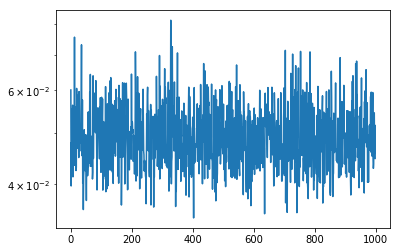

In [36]:
cs = []
for k in range(1000):
    ids = np.random.choice(len(faces), 3, replace=False)
    batch = ((blur_faces[ids] - mean) / std, (faces[ids] - mean) / std)

    _, c = sess.run([_t, _c], feed_dict={_x: batch[0], _y: batch[1]})
    if k % 10 == 0:
        print("{} {:.3f}".format(k, math.sqrt(c)))
    cs.append(math.sqrt(c))

plt.semilogy(range(1000), cs)

In [31]:
def compare(image, blur):
    unblur = sess.run(_r, feed_dict={_x: [blur]})[0]

    mi = min(np.min(image), np.min(blur), np.min(unblur))
    ma = max(np.max(image), np.max(blur), np.max(unblur))
    
    fig = plt.figure(figsize=(15, 13))
    a = fig.add_subplot(1,3,1)
    img = a.imshow((image - mi) / (ma - mi))
    #img.set_cmap('gray')
    a.axis('off')

    a = fig.add_subplot(1,3,2)
    img = a.imshow((blur - mi) / (ma - mi))
    #img.set_cmap('gray')
    a.axis('off')

    a = fig.add_subplot(1,3,3)
    img = a.imshow((unblur - mi) / (ma - mi))
    #img.set_cmap('gray')
    a.axis('off')

    plt.tight_layout()

In [32]:
obama = (imread('test/WDF_2678055.png', mode='RGB').astype(np.float32) / 255 - mean) / std
obama = zoom(obama, (faces.shape[1]/obama.shape[0], faces.shape[2]/obama.shape[1], 1))
blur_obama = gaussian_filter(obama, (3, 3, 0))

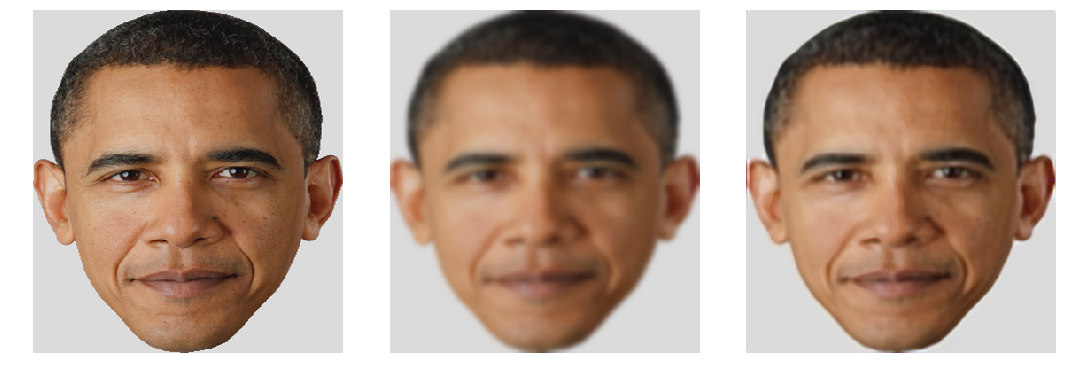

In [43]:
compare(obama, blur_obama)

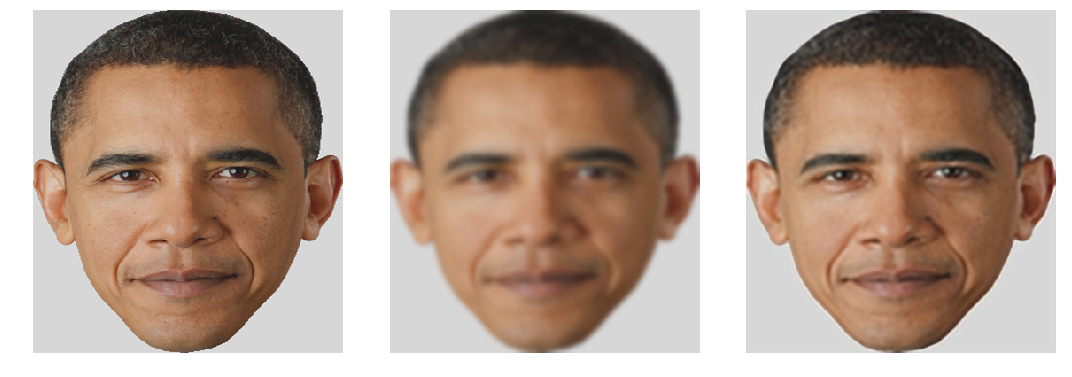

In [38]:
compare(obama, blur_obama)